<a href="https://colab.research.google.com/github/dercodeKoenig/dqn_trading_gcloudvm/blob/main/evaluate_colab_gdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/dqn_training/dqn_trading_gcloudvm/t1

/content/drive/MyDrive/dqn_training/dqn_trading_gcloudvm/t1


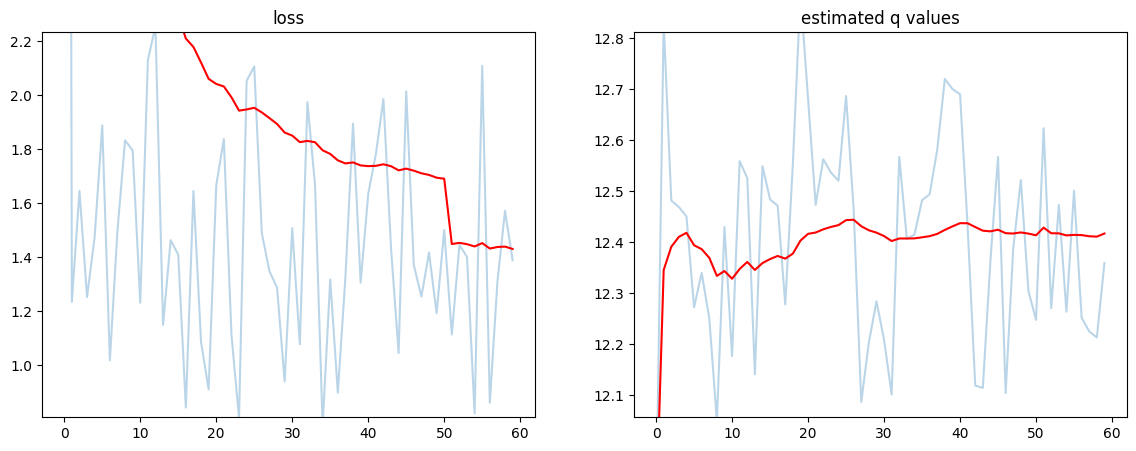

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def get_values(fn):
    f = open(fn)
    lines = f.readlines()
    f.close()

    lines = [float(x.replace("\n","")) for x in lines]
    for i in range(len(lines)):
        if np.isnan(lines[i]):
            lines[i] = 0

    return lines

avg_n=50
k=2

def plot_logs(losses, qs, name):
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].set_title("loss")
    lower, upper = np.percentile(losses, [k, 100-k])
    ax[0].set_ylim(lower, upper)
    ax[0].plot(losses, alpha=0.3)
    ax[0].plot([np.mean(losses[max(0,i-avg_n):i+1]) for i in range(len(losses))], c="r")
    ax[1].set_title("estimated q values")
    lower, upper = np.percentile(qs, [k, 100-k])
    ax[1].set_ylim(lower, upper)
    ax[1].plot(qs, alpha=0.3)
    ax[1].axhline(0)
    ax[1].plot([np.mean(qs[max(0,i-avg_n):i+1]) for i in range(len(qs))], c="r")
    plt.savefig(name)


losses = get_values("loss.txt")
qs = get_values("qv.txt")
plot_logs(losses, qs, "t1.jpg")


In [ ]:
from manager import *
from utils import *
from make_model import *

import tensorflow as tf
import time
from manager import candle_class
import random
import numpy as np
from collections import deque
import time
import os

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
path2 = "US500_1.o"
path1 = "USTEC_1.o"
cm = 0.9

In [ ]:

class match_time_cor_market:
    def __init__ (self,path):
        self.path = path
        self.candle_index = 0
        self.candles = Load(self.path)
        self.last_candle = candle_class(0,0,0,0,[1,1,2000,0,0,0])
        self.time_int2 = 0

    def get_next_candle(self):
        if self.candle_index >= len(self.candles):
          print("error - no more candles")
          return -1

        self.last_candle = self.candles[self.candle_index]
        self.candle_index+=1
        return 0


    def get_candle_by_time_match(self, t):
        t = t.split(":")
        t = [int(x) for x in t]
        time_int1 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]



        while self.time_int2 < time_int1:
            if self.get_next_candle() == 0:
                t = self.last_candle.t
                t = t.split(":")
                t = [int(x) for x in t]
                self.time_int2 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]
            else:
                return -1

        #print(time_int1, self.time_int2)

        if self.time_int2 == time_int1:
            return self.last_candle
        if self.time_int2 > time_int1:
            #print("candle data missing - skip candle")
            return self.last_candle


In [ ]:
data_dir = "data/"
path1 = data_dir+path1
path2 = data_dir+path2

start = 1760000

path1: data/parts_ENQ_1_inverted.o/
path: data/parts_EP_1_inverted.o/
cm: 0.9
start at parts_ENQ_1_inverted.o - 6500000


In [ ]:
model = make_model()
model.load_weights("dqn_weights.h5")

In [ ]:
candle_counter = -1
last_state = 0

x = manager()
x2 = manager()

c_match_system = match_time_cor_market(path2)

position = 0
balance = 0
equity_list = []
balances = []
vol = 1

outputs = []
candle_position_history = []

entry_price = -1
reset_entry_price = False


def close(c):
    global balance, position, entry_price
    balance += (c - entry_price) * vol * position
    balance -= cm / 2 * vol
    position = 0
    entry_price = -1


sample_counter = 0

candles = Load(path1)
for i in range(0, len(candles)):
                candle_counter+=1

                candle2 = c_match_system.get_candle_by_time_match(candles[i].t)
                if candle2 == -1:
                    print("secondary data file ended - break")
                    break

                ret2 = x2.push_m1_candle(candle2)
                ret = x.push_m1_candle(candles[i])

                if candle_counter>=start:

                    #disable relative scaling
                    #ret[0][1] = 1
                    #########

                    inp = get_inputs_from_ret(ret, x)
                    inp2 = get_inputs_from_ret(ret2, x2)
                    inp2 = [inp2[0]] + [inp2[3]] + [inp2[4]] + [inp2[5]]

                    new_state = [position]+inp+inp2


                    m_input = [np.expand_dims(new_state[i], axis=0) for i in range(len(new_state))]
                    o = model(m_input) # scores: short, long, neutral
                    o = o.numpy().tolist()[0]
                    #o[2] = -999
                    action = np.argmax(o)


                    if reset_entry_price:
                        entry_price = x.m1_candles[-1].o
                        reset_entry_price = False

                    candle_position_history.append([x.m1_candles[-1], position])




                    c = x.m1_candles[-1].c
                    open_profit = position * vol * (c - entry_price)

                    if action == 0: # short
                        if position != -1:
                            close(c)
                            position = -1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 1: # long
                        if position != 1:
                            close(c)
                            position = 1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 2: # neutral
                        if position != 0:
                            close(c)

                    balances.append(balance)


                    equity = balance + open_profit
                    equity_list.append(equity)

                    #print([ round(i,2) for i in  o.numpy().flatten().tolist() ], position, balance, equity)
                    sample_counter+=1
                    if sample_counter % 100 == 0:
                        print(sample_counter, position, equity)

                    outputs.append(o)

                    if sample_counter >= 23*60*5*4:
                        break

In [ ]:
#new_state

In [ ]:
import matplotlib.pyplot as plt
short_predictions = [x[0] for x in outputs]
long_predictions = [x[1] for x in outputs]
neutral_predictions = [x[2] for x in outputs]


_, ax = plt.subplots(2,1)
ax[0].plot(short_predictions, c="r")
ax[0].plot(long_predictions, c="g")
#ax[0].plot(neutral_predictions, c="b")


for index,i in enumerate(candle_position_history):
    o = i[0].o
    c = i[0].c
    if i[1] == -1:
        color = "r"
    if i[1] == 1:
        color = "g"
    if i[1] == 0:
        color = "b"
    ax[1].plot([index,index],[o,c],c=color)

In [ ]:
x.m1_candles[-1].t

In [ ]:
plt.plot(equity_list)

In [ ]:
equity_list

In [ ]:
model(m_input)

for i in range(len(model.layers)):
  tm = tf.keras.Model(inputs = model.inputs, outputs=model.layers[i].output)
  out = tm(m_input)

  print(model.layers[i].name)
  print(out)
